
Imports

In [2]:
import os

from sklearn.cluster import HDBSCAN
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from langchain_core.messages import SystemMessage
from langchain_core.prompts import (
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate
)

# Import Azure OpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain_openai import AzureChatOpenAI

from dotenv import load_dotenv

from collections import Counter

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, "../../")
from reclaim_tiktok.classifier.classifier import Classifier

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import textwrap

Load environment variables

In [5]:
# Construct an absolute path to where your .env file is located
dotenv_path = os.path.join(os.getcwd(), '.env')
result = load_dotenv(dotenv_path)
print(result)  # This should print True if the file is loaded successfully

False


Prepare deployed Azure OpenAI models

[Deployed models in Azure Portal](https://oai.azure.com/portal/fdd568fbdff34acfbd92a47db2fa9f36/deployment?tenantid=e23925be-c276-4284-897f-ca99bfbeed44)


In [6]:

embeddings_client = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-small-eastus",
    openai_api_version="2024-02-01",
)

llm_client = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_deployment="gpt-35-turbo-16k",
)

# TikTok data

## Get test data from csv

In [81]:
path_csv= "../../data/"
df = pd.read_csv(path_csv+"videos_with_core_messages_clusters.csv")

In [82]:
# Convert the strings in the "cluster" column to lists of strings
cl_li = df['cluster'].str.split(";").explode()
cm_li= df['core_message'].str.replace("['", "").str.replace("]", "").str.split(r"', '").explode()

In [97]:
cm_li

0       Streik in Deutschland: Züge, Autobahnen und St...
0       Bauern, LKW-Fahrer und Gastronomen beteiligen ...
0       Unzufriedenheit mit politischer Lage führt zu ...
1       falls sie in einem Land leben in dem sie für d...
2       Bürgergeld, Angst vor Sarah Wagenknecht, deuts...
                              ...                        
2060    - Erdogan bezeichnet Israel als Terrorstaat un...
2060    - Erdogan verteidigt die Hamas und kritisiert ...
2060    - Erdogan fordert Anklage gegen Israel vor dem...
2061    du kennst die deutsche Außenministerin oder An...
2062    das Osterfest steht vor der Tür und damit 1 pa...
Name: core_message, Length: 5212, dtype: object

In [106]:
cl_li

0       22
0        2
0       18
1        7
2       13
        ..
2060    11
2060    11
2060     5
2061    15
2062    19
Name: cluster, Length: 5222, dtype: object

In [98]:
df_cm = pd.merge(cm_li, df, left_index=True, right_index=True, how='left')

In [102]:
len(df_cm)

TypeError: len() takes no keyword arguments

In [105]:
cl_li

0       22
0        2
0       18
1        7
2       13
        ..
2060    11
2060    11
2060     5
2061    15
2062    19
Name: cluster, Length: 5222, dtype: object

In [104]:
len(list(cl_li))

5222

In [99]:
df_cm['cluster']=list(cl_li)

ValueError: Length of values (5222) does not match length of index (5212)

In [61]:
cl_li.explode()

0        8
0        8
0        5
1       11
2        5
        ..
2058     0
2059     4
2060    20
2061     6
2062     7
Name: cluster, Length: 2369, dtype: object

In [57]:
df['core_message'][0]

"['- Mega Streik am 08.0 in Deutschland', '- Züge, Bauern, LKW-Fahrer und Gastronomen beteiligen sich', '- Bevölkerung unzufrieden mit politischer Lage und Kostensteigerungen']"

In [58]:
string = "['- Mega Streik am 08.0 in Deutschland', '- Züge, Bauern, LKW-Fahrer und Gastronomen beteiligen sich', '- Bevölkerung unzufrieden mit politischer Lage und Kostensteigerungen']"

# Remove the leading and trailing square brackets and single quotes
string = string.strip("[]'")

# Split the string along ', '
separated_list = string.split("', '")

print(separated_list)


['- Mega Streik am 08.0 in Deutschland', '- Züge, Bauern, LKW-Fahrer und Gastronomen beteiligen sich', '- Bevölkerung unzufrieden mit politischer Lage und Kostensteigerungen']


In [40]:
# Create a new DataFrame to store the result
# Convert the strings in the "core_message" column to lists of strings
df['core_message'] = df['core_message'].str.split("', '")

# Convert the strings in the "cluster" column to lists of strings
df['cluster'] = df['cluster'].str.split(";")

# Combine the "core_message" and "cluster" columns into tuples
df['combined'] = list(zip(df['core_message'], df['cluster']))

# Explode the "combined" column along each entry in the list
df_split = df.explode('combined', ignore_index=True)

# Split the "combined" column into separate columns again
df_split[['core_message', 'cluster']] = pd.DataFrame(df_split['combined'].tolist(), index=df_split.index)

# Drop the "combined" column
df_split.drop(columns=['combined'], inplace=True)

ValueError: Columns must be same length as key

In [33]:
df_split

,Unnamed: 0.1,Unnamed: 0,video_id,video_timestamp,video_duration,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,...,author_videocount,author_diggcount,author_verified,suggested_words,url,english_transcript,german_transcript,error_reason,core_message,cluster
0,0,1,7320578484609256736,1704455008,69,196185,68661,9390,6522042,Seit ihr dabei beim streik #streiken #streik81...,...,190,488,False,"['streiken', 'streik8124', 'bauernstreik', 'am...",https://www.tiktok.com/@zeitzeugengenausdemkri...,urgent breaking news! mega strike on 08.01. i...,dringende Eilmeldung! mega Streik am 08.01. in...,NaN,['- Mega Streik am 08.0 in Deutschland,8;8;5
1,0,1,7320578484609256736,1704455008,69,196185,68661,9390,6522042,Seit ihr dabei beim streik #streiken #streik81...,...,190,488,False,"['streiken', 'streik8124', 'bauernstreik', 'am...",https://www.tiktok.com/@zeitzeugengenausdemkri...,urgent breaking news! mega strike on 08.01. i...,dringende Eilmeldung! mega Streik am 08.01. in...,NaN,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",8;8;5
2,0,1,7320578484609256736,1704455008,69,196185,68661,9390,6522042,Seit ihr dabei beim streik #streiken #streik81...,...,190,488,False,"['streiken', 'streik8124', 'bauernstreik', 'am...",https://www.tiktok.com/@zeitzeugengenausdemkri...,urgent breaking news! mega strike on 08.01. i...,dringende Eilmeldung! mega Streik am 08.01. in...,NaN,- Bevölkerung unzufrieden mit politischer Lage...,8;8;5
3,1,3,7259813032321092891,1690306946,25,423464,44431,11512,6056046,Alice Weidel💙🇩🇪💙 #edit #aliceweidel #deutschla...,...,22,135,False,"['edit', 'aliceweidel', 'deutschland', 'afd', ...",https://www.tiktok.com/@wirsinddasvolkde/video...,If they live in a country where they are penal...,falls sie in einem Land leben in dem sie für d...,NaN,['falls sie in einem Land leben in dem sie für...,11
4,2,4,7317232563129552161,1703675984,61,208353,2390,5403,5817725,Fragenhagel mit Alice Weidel (AfD) #fy #foryou...,...,94,1354,False,"['fy', 'foryou', 'foryoupage', 'fürdich', 'für...",https://www.tiktok.com/@denzho/video/731723256...,Citizen income or basic income? Neither Are y...,Bürgergeld oder Grundeinkommen? Keins von beid...,NaN,['- Kein Bürgergeld oder Grundeinkommen,5;12;11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362,2058,4917,7339988922472205601,1708974350,59,139,19,17,515,#Duett mit @Fra Nk #breakingnews #aktuellerden...,...,188,17600,False,"['duett', '', 'breakingnews', 'aktuellerdennje...",https://www.tiktok.com/@nicky198809/video/7339...,NaN,der Staat enteignet uns und macht 500 oder 1.0...,NaN,"[""der Staat enteignet uns und macht 500 oder 0...",0
2363,2059,4920,7347380271265680672,1710695284,49,66,1,7,503,#Duett mit @HaRaLdBeStE #rechts #aktuellerdenn...,...,188,17600,False,"['duett', '', 'rechts', 'aktuellerdennje', 'de...",https://www.tiktok.com/@nicky198809/video/7347...,NaN,ich bin rechts urteilst du. und damit bist du ...,NaN,['ich bin rechts urteilst du. und damit bist d...,4
2364,2060,4921,7302847678910680353,1700326732,96,65,0,12,500,NaN,...,109,39300,False,"['fy', 'fyp', 'foryou', 'foryoupage', 'erdogan...",https://www.tiktok.com/@talos1967.4/video/7302...,NaN,der türkische Präsident Richard taiheb Erdogan...,NaN,['der türkische Präsident Richard taiheb Erdog...,20
2365,2061,4934,7288696383404641568,1697031876,23,59,64,4,420,#fürunserekinder #aliceweidelmeinekanzlerin #b...,...,3353,31000,False,"['fürunserekinder', 'aliceweidelmeinekanzlerin...",https://www.tiktok.com/@jurgenafd/video/728869...,NaN,du kennst die deutsche Außenministerin oder An...,NaN,['du kennst die deutsche Außenministerin oder ...,6


In [ ]:
df_split_2 = df.explode('cluster')

### Cluster naming with GPT

In [21]:
#Der Titel sollte das gemeinsame Narrativ bestmöglichst beschreiben. Beispiele sind:  Positionierung gegen Einwanderung, Forderung die kulturelle Identität zu schützen oder aufzubauen, Hinterfragen des Vorgehens der EU, nationale Souveränität betonen, Forderung nach einer harten Hand gegen Kriminalität und Terrorismus, Hetzerischer Angriff und Kritik an Grünen ohne konstruktive Gegenvorschläge.
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "Du bist ein Experte im Schreiben. Du hilfst mir, einen gemeinsames Narrativ für mehrere ähnliche TikTok-Beiträge zu schreiben. Analysiere welche Themen besonders oft aufgegriffen werden und finde eine sehr kurze Beschreibung "
            )
        ),
        HumanMessagePromptTemplate.from_template("Schreibe anhand der folgenden deutschen Transkripte und Beschreibungen von Tiktok-Videos eine und nur eine möglichst genaue und treffende analytische Beschreibung des Narrativs der Videos. Die Beschreibung sollte maximal aus 10 Wörtern bestehen, keine Übertitel, keine Anführungsstriche: \n\nPOSTS:{posts}\n\nTOPIC TITLE:"),
    ]
)

In [22]:
#try out with stopwords

german_stop_words= open("../../data/clustering/german_stopwords_full.txt").read().split()[53:]

In [23]:
for c in sorted(df_cm.cluster.unique()):
    try:
        print(c)
        # Generate posts string
        posts_str = "\n".join(
            f"{post['core_message']}\n" #\n{post['suggested_words']}{post['video_description']}\n
            for post in df_cm.query(f"cluster == {c}").to_dict(orient="records")
        )
        posts_str = ' '.join([word for word in posts_str.split() if word not in (german_stop_words)])

        # limit str to maximum token length of model 16384
        print(len(posts_str))
        posts_str = posts_str[:16384]
        posts_str = posts_str.replace("Kanacke", "Ausländer")
        # Create prompt
        #prompt = get_prompt(articles_str)
        prompt = chat_template.format_messages(posts=posts_str)
        # Invoke the model and pass the generated prompt
        result = llm_client.invoke(prompt)
        #print(result)

        # Assuming result extraction based on your specific response structure
        df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content
    except Exception as e:
        print("content warning triggered for cluster "+str(c))
        posts_str = "\n".join(
            f"{post['core_message']}\n" #\n{post['suggested_words']}{post['video_description']}\n
            for post in df_cm.query(f"cluster == {c}").to_dict(orient="records")
        )
        #posts_str = ' '.join([word for word in posts_str.split() if word not in (german_stop_words)])

        # limit str to maximum token length of model 16384
        posts_str = posts_str[:16384]
        # Create prompt
        #prompt = get_prompt(articles_str)
        prompt = chat_template.format_messages(posts=posts_str)
        # Invoke the model and pass the generated prompt
        result = llm_client.invoke(prompt)
        # Assuming result extraction based on your specific response structure
        df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content
        continue

0
24766
1
10216
2
16555
3
21275
4
18039
5
9277
6
7741
7
12720
8
5930
9
13167
10
23401
11
10535
12
14068
13
12673
14
81677
content warning triggered for cluster 14
15
10151
16
14592
17
13348
18
9866
19
11907
20
6941
21
6228
22
13902
23
11991


In [24]:
df_cm

,Unnamed: 0.1,Unnamed: 0,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp
0,0,0,Streik am 08.0 in Deutschland - größter Streik...,5,7320578484609256736,6522042,Protestbewegung gegen die Regierung und politi...,1704455008
1,1,1,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",11,7320578484609256736,6522042,Bauernproteste gegen politische Entscheidungen...,1704455008
2,2,2,- Unzufriedenheit mit politischer Lage und Geh...,7,7320578484609256736,6522042,Ungerechtigkeiten im deutschen Sozialsystem un...,1704455008
3,3,3,falls sie in einem Land leben in dem sie für d...,3,7259813032321092891,6056046,"""Kontroverse zur Migrationspolitik und Integra...",1690306946
4,4,4,- Bürgergeld oder Grundeinkommen? Keins von be...,7,7317232563129552161,5817725,Ungerechtigkeiten im deutschen Sozialsystem un...,1703675984
...,...,...,...,...,...,...,...,...
4730,4730,4730,- Erdogan bezeichnet Israel als Terrorstaat un...,13,7302847678910680353,500,Gewaltkriminalität und Sicherheitsbedenken,1700326732
4731,4731,4731,"- Erdogan bekräftigt, dass die Hamas keine Ter...",13,7302847678910680353,500,Gewaltkriminalität und Sicherheitsbedenken,1700326732
4732,4732,4732,- Erdogan fordert Anklage gegen Israel vor dem...,13,7302847678910680353,500,Gewaltkriminalität und Sicherheitsbedenken,1700326732
4733,4733,4733,du kennst die deutsche Außenministerin oder An...,14,7288696383404641568,420,"""Kritik an Politik und Regierung, Angriffe auf...",1697031876


In [35]:
new_df = df_cm.groupby('video_id').agg({
    'cluster': lambda x: ';'.join(str(v) for v in x),
    'core_message': lambda x: ';'.join(str(v) for v in x),
    'video_playcount': 'first',     # Retain the first play count
    'video_timestamp': 'first'      # Retain the first timestamp
}).reset_index()


# Display the new DataFrame
print(new_df)

                 video_id   cluster  \
0     7005858788343319813        23   
1     7040421798785125638   1;22;15   
2     7052592640344329477        13   
3     7069273153373097221  22;17;17   
4     7080134745832557830    16;1;0   
...                   ...       ...   
2065  7365836620957814049        16   
2066  7365899292927741216         7   
2067  7365925784864722209     3;3;3   
2068  7366492764877442336        23   
2069  7366589435703594273         2   

                                           core_message  video_playcount  \
0     Mach so bisschen Übergang deine Haare kürzer d...           613338   
1      Kritik an ungeimpftem Personal in der Pflege;...            30603   
2     7 Millionen sozialgeldempfänger davon gut die ...            27175   
3     - Hohe Anzahl von Arztbesuchen aufgrund von Im...           235154   
4      Unterschied zwischen Gesundheitspolitik und p...             7439   
...                                                 ...              ...   

In [71]:
new_df=pd.read_csv(path_csv+"1405_data_with_clusters.csv")

In [78]:
merged_df = pd.merge(new_df, df_clean[['video_id', 'english_transcript']], on='video_id', how='left')
merged_df = pd.merge(merged_df, df_clean[['video_id', 'german_transcript']], on='video_id', how='left')


In [79]:
merged_df

,Unnamed: 0,video_id,cluster,core_message,video_playcount,video_timestamp,english_transcript,german_transcript
0,0,7005858788343319813,23,Mach so bisschen Übergang deine Haare kürzer d...,613338,1631178624,NaN,Mach so bisschen Übergang deine Haare kürzer d...
1,1,7040421798785125638,1;22;15,Kritik an ungeimpftem Personal in der Pflege;...,30603,1639225941,NaN,nötigerweise Menschen sterben weil Ungeimpfte ...
2,2,7052592640344329477,13,7 Millionen sozialgeldempfänger davon gut die ...,27175,1642059688,NaN,7 Millionen sozialgeldempfänger davon gut die ...
3,3,7069273153373097221,22;17;17,- Hohe Anzahl von Arztbesuchen aufgrund von Im...,235154,1645943422,NaN,und zu den Nebenwirkungen das äh Nebenwirkunge...
4,4,7080134745832557830,16;1;0,Unterschied zwischen Gesundheitspolitik und p...,7439,1648472331,NaN,sehr geehrte frau präsidentin kolleginnen und ...
...,...,...,...,...,...,...,...,...
2065,2065,7365836620957814049,16,Politiker werden angegriffen; Regierung ist bü...,20283,1714992492,recently are increasingly common Politician an...,in jüngster Zeit sind immer häufiger Politiker...
2066,2066,7365899292927741216,7,"Deutschland ist unsere Heimat, unser Land, uns...",8263,1715007082,"Germany is our home, our country, our nation ...","Deutschland ist unsere Heimat, unser Land, uns..."
2067,2067,7365925784864722209,3;3;3,- Definition des deutschen Staatsangehörigen i...,1323,1715013248,NaN,"ne, es geht um Artikel 1 äh, Absatz 1. Deutsch..."
2068,2068,7366492764877442336,23,sie wissen ja wofür Antifa steht oder nein dan...,38494,1715145281,you know what Antifa stands for or no then I'l...,sie wissen ja wofür Antifa steht oder nein dan...


In [80]:
merged_df.to_csv(path_csv+"1405_data_with_clusters.csv")

In [39]:
new_df.to_csv(path_csv+"1405_data_with_clusters.csv")
topic_title=[df_cm.query(f"cluster == {c}").topic_title.values[0] for c in sorted(df_cm.cluster.unique())]
df_topic_title=pd.DataFrame(topic_title, columns=["topic_title"])
df_topic_title["cluster_number"]=np.arange(24)
df_topic_title.to_csv(path_csv+"1405_data_topic_title.csv")

In [14]:
df_cm.to_csv(path_csv+"df_cm.csv")
#df_cm=pd.read_csv(path_csv+"df_cm.csv")

In [125]:
# find the most central datapoint # adjust this code for most cosine clim

# Loop over all clusters and find index of closest point to the cluster center and append to closest_pt_idx list.
closest_pt_idx = []
for iclust in range(kmeans.n_clusters):
    # get all points assigned to each cluster:
    cluster_pts = embeddings_cm[kmeans.labels_ == iclust]
    # get all indices of points assigned to this cluster:
    cluster_pts_indices = np.where(kmeans.labels_ == iclust)[0]

    cluster_cen = kmeans.cluster_centers_[iclust]
    min_idx = np.argmax([cosine_similarity([embeddings_cm[idx]], [cluster_cen])[0] for idx in cluster_pts_indices])
    
    # Testing:    
    #print('closest point to cluster center: ', cluster_pts[min_idx])
    #print('closest index of point to cluster center: ', cluster_pts_indices[min_idx])
    closest_pt_idx.append(cluster_pts_indices[min_idx])

In [25]:
counter=Counter(labels)
count_arr = sorted([[key, value] for key, value in counter.items()])
summed_reach=[sum(df_cm.query(f"cluster == {c}").video_playcount.values) for c in sorted(df_cm.cluster.unique())]
topic_title=[df_cm.query(f"cluster == {c}").topic_title.values[0] for c in sorted(df_cm.cluster.unique())]

topic_title

['AfD in Deutschland: Kontroverse Politik und wachsende Unterstützung',
 'Unzufriedenheit und Kritik an der deutschen Regierung',
 'Gesellschaftliche Missstände und persönliche Erfahrungen werden thematisiert.',
 '"Kontroverse zur Migrationspolitik und Integration in Deutschland"',
 '"Energiekosten und Klimawandel: Herausforderungen und Kontroversen"',
 'Protestbewegung gegen die Regierung und politische Missstände in Deutschland.',
 'Kritik an der grünen Politik in Deutschland',
 'Ungerechtigkeiten im deutschen Sozialsystem und Rentensystem',
 '"Unterstützung und Kritik im Ukraine-Russland Konflikt"',
 'Deutschland: Politische Kritik und Problemlösungen',
 'Aktivistischer Aufruf für Einigkeit, politische Veränderungen und gesellschaftliche Solidarität.',
 'Bauernproteste gegen politische Entscheidungen in der Landwirtschaft.',
 '"Deutschland in der Krise: Probleme, Verantwortung und Identität"',
 'Gewaltkriminalität und Sicherheitsbedenken',
 '"Kritik an Politik und Regierung, Angriff

In [169]:
for c in sorted(df_cm.cluster.unique()):
        
    with pd.option_context("display.max_colwidth", None):
        #print cluster id
        print(f"Cluster {c} "+ str(count_arr[c][1]))
        print(df_cm.query(f"cluster == {c}").topic_title.values[0])
        print(sum(df_cm.query(f"cluster == {c}").video_playcount.values))
        print(np.array(df_cm["video_id"])[closest_pt_idx[c]])
       #display(df.query(f"cluster == {c}").drop(columns=["topic_title"]).head())

Cluster 0 156
Gewalt und Extremismus in Deutschland
39432683
7323183991287237921
Cluster 1 110
Integration und Ausländerpolitik Deutschlands
48702213
7348044338405887264
Cluster 2 159
Proteste und Forderungen der Landwirte gegen die Politik
36852935
7322729533025701153
Cluster 3 280
Kritik an der deutschen Regierung und Politik
59960529
7124743885779209477
Cluster 4 125
Klimawandel und Klimaschutzdebatten in Deutschland.
30956144
7220497032518044955
Cluster 5 188
Kritik an der aktuellen Regierung und ihren Entscheidungen.
40118319
7321730128579513633
Cluster 6 117
Kritik an Medienmanipulation und fehlender Neutralität
23127601
7325004424554843425
Cluster 7 193
Kritik an Migrationspolitik und Forderung nach Abschiebung
41831518
7325844420723576096
Cluster 8 364
Das Narrativ der TikTok-Videos dreht sich um die Unterstützung und Kritik der AfD sowie um die Forderung nach Veränderung und politischem Wandel in Deutschland.
67825338
7249998061433376027
Cluster 9 159
Der Ukraine-Konflikt und 

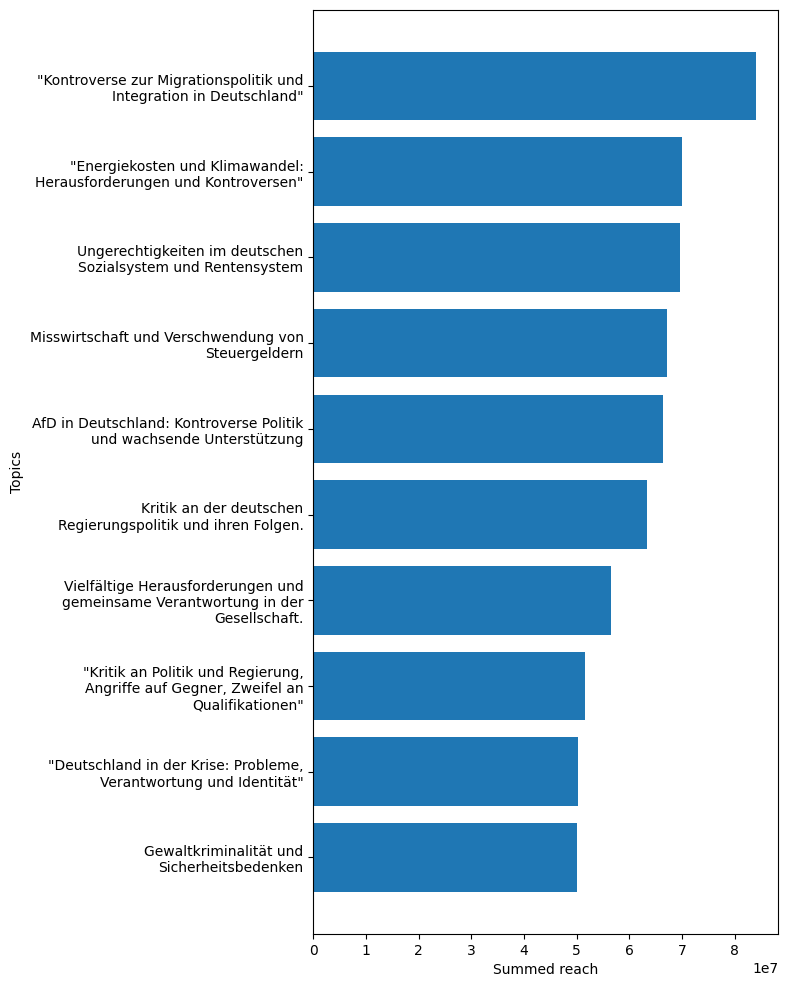

In [33]:
plt.figure(figsize=(6, 12))  # Adjust figure size as needed
wrapped_titles = [textwrap.fill(title, width=40) for title in topic_title]
sorted_data = sorted(zip(wrapped_titles, summed_reach), key=lambda x: x[1], reverse=True)
sorted_titles, sorted_reach = zip(*sorted_data)

plt.barh(sorted_titles[:10],sorted_reach[:10])  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Summed reach')
plt.ylabel('Topics')
#plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

In [34]:


mean_reach=[]
for c in range(24):
    cluster_pts = embeddings_cm[kmeans.labels_ == c]
    X=embeddings_cm[df_cm.query(f"cluster == {c}").index]
    reach=df_cm.query(f"cluster == {c}").video_playcount
    cluster_cen = kmeans.cluster_centers_[c]
    cluster_pts_indices = df_cm.query(f"cluster == {c}").index
    body = [1- cosine_similarity([embeddings_cm[idx]], [cluster_cen])[0,0] for idx in cluster_pts_indices]
    
    mean_reach.append(np.mean(reach[np.array(body)<0.6]))
    #print("Average Reach for cluster "+ str(c)+ ":", mean_reach)

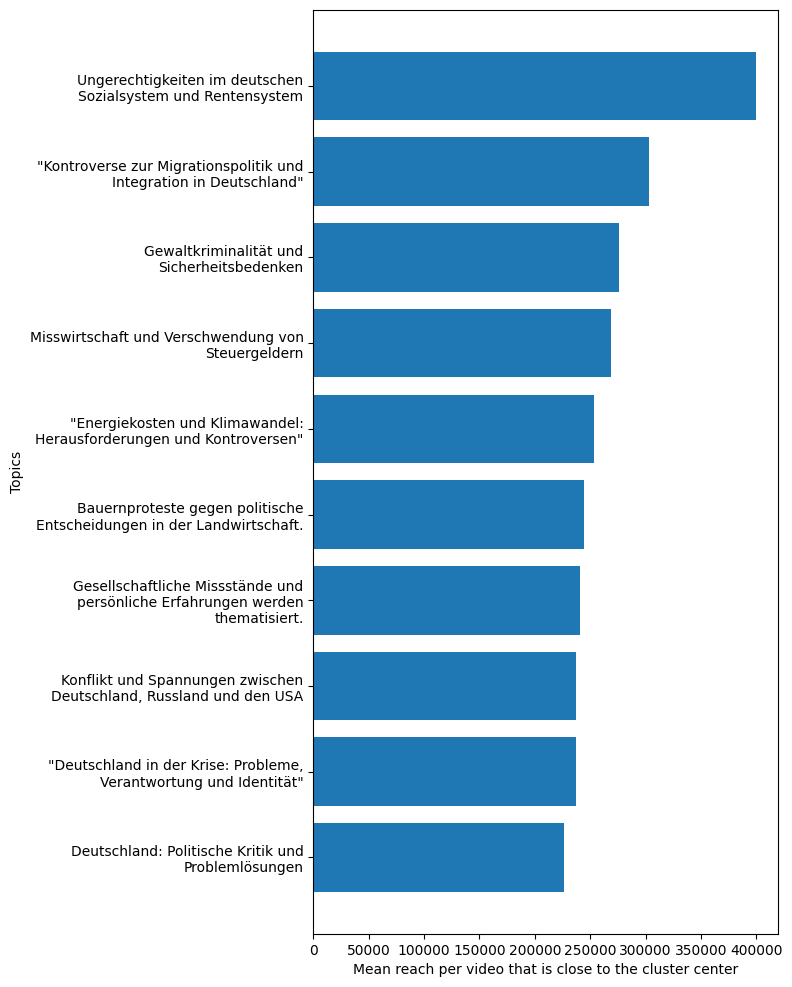

In [35]:
#display most viral topics 

plt.figure(figsize=(6, 12))  # Adjust figure size as needed
wrapped_titles = [textwrap.fill(title, width=40) for title in topic_title]
sorted_data = sorted(zip(wrapped_titles, mean_reach), key=lambda x: x[1], reverse=True)
sorted_titles, sorted_reach = zip(*sorted_data)

plt.barh(sorted_titles[:10],sorted_reach[:10])

# Adding labels and title
plt.xlabel('Mean reach per video that is close to the cluster center')
plt.ylabel('Topics')
#plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

## Compare reach between Official Afd-Acocunts and other

In [39]:
df_accounts_afd=pd.read_csv(path_csv+"Accounts_german_politics_Tik_Tok_Martin_Fuchs .csv", skiprows=1)

In [42]:
df_accounts_afd['Tik Tok-Profil'] = df_accounts_afd['Tik Tok-Profil'].str.replace('https://www.tiktok.com/@', '')
df_accounts_afd = df_accounts_afd[df_accounts_afd['Partei'] == 'AfD']
df_accounts_afd = df_accounts_afd.rename(columns={'Tik Tok-Profil': 'author_username'})
len(df_accounts_afd)

174

In [36]:
df_cm = pd.merge(df_cm, df[['video_id', 'author_username']], on='video_id', how='left')
df_cm


,Unnamed: 0.1,Unnamed: 0,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp,author_username
0,0,0,Streik am 08.0 in Deutschland - größter Streik...,5,7320578484609256736,6522042,Protestbewegung gegen die Regierung und politi...,1704455008,zeitzeugengenausdemkrieg
1,1,1,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",11,7320578484609256736,6522042,Bauernproteste gegen politische Entscheidungen...,1704455008,zeitzeugengenausdemkrieg
2,2,2,- Unzufriedenheit mit politischer Lage und Geh...,7,7320578484609256736,6522042,Ungerechtigkeiten im deutschen Sozialsystem un...,1704455008,zeitzeugengenausdemkrieg
3,3,3,falls sie in einem Land leben in dem sie für d...,3,7259813032321092891,6056046,"""Kontroverse zur Migrationspolitik und Integra...",1690306946,wirsinddasvolkde
4,4,4,- Bürgergeld oder Grundeinkommen? Keins von be...,7,7317232563129552161,5817725,Ungerechtigkeiten im deutschen Sozialsystem un...,1703675984,denzho
...,...,...,...,...,...,...,...,...,...
4730,4730,4730,- Erdogan bezeichnet Israel als Terrorstaat un...,13,7302847678910680353,500,Gewaltkriminalität und Sicherheitsbedenken,1700326732,talos1967.4
4731,4731,4731,"- Erdogan bekräftigt, dass die Hamas keine Ter...",13,7302847678910680353,500,Gewaltkriminalität und Sicherheitsbedenken,1700326732,talos1967.4
4732,4732,4732,- Erdogan fordert Anklage gegen Israel vor dem...,13,7302847678910680353,500,Gewaltkriminalität und Sicherheitsbedenken,1700326732,talos1967.4
4733,4733,4733,du kennst die deutsche Außenministerin oder An...,14,7288696383404641568,420,"""Kritik an Politik und Regierung, Angriffe auf...",1697031876,jurgenafd


In [46]:
# Merge df_cm with df_accounts_afd based on the account username
merged_df = pd.merge(df_cm, df_accounts_afd[['author_username']], on='author_username', how='inner')
merged_df

,Unnamed: 0.1,Unnamed: 0,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp,author_username
0,13,13,Abzocke durch Angstmache: Parallele zwischen K...,4,7277845870819724576,3090313,"""Energiekosten und Klimawandel: Herausforderun...",1694505554,mutzurwahrheit90
1,14,14,Erhöhung der LKW-Maut um 85% ab 2023,16,7277845870819724576,3090313,Misswirtschaft und Verschwendung von Steuergel...,1694505554,mutzurwahrheit90
2,15,15,Erhöhung der CO2-Steuer um 50% ab 2024,4,7277845870819724576,3090313,"""Energiekosten und Klimawandel: Herausforderun...",1694505554,mutzurwahrheit90
3,42,42,Politischer Missbrauch von TikTok im Landtag,15,7170813730643660037,2182966,"""Kritik an staatlichem Missbrauch und Verletzu...",1669585181,mutzurwahrheit90
4,43,43,Verbreitung von Fake News und fehlende Korrek...,19,7170813730643660037,2182966,"""Debatte über Meinungsfreiheit und Medienmanip...",1669585181,mutzurwahrheit90
...,...,...,...,...,...,...,...,...,...
605,4623,4623,"Unterstützung für Bau und Wohnen, insbesonder...",7,7083394344442432774,1174,Ungerechtigkeiten im deutschen Sozialsystem un...,1649231269,andywinhart
606,4624,4624,Verstoß gegen die Schuldenbremse durch Verwen...,16,7083394344442432774,1174,Misswirtschaft und Verschwendung von Steuergel...,1649231269,andywinhart
607,4703,4703,Kritik an Resolution zur Migration und Asyl i...,22,7329650186232335649,649,Kritik an der deutschen Regierungspolitik und ...,1706567177,nicolehoechst_mdb
608,4704,4704,Sorge um Einschränkung der Meinungsfreiheit u...,19,7329650186232335649,649,"""Debatte über Meinungsfreiheit und Medienmanip...",1706567177,nicolehoechst_mdb


In [62]:
len(merged_df)

2070

In [65]:
# Filter df_cm for account names that are in df_accounts_afd
afd_accounts_cm = df_cm[df_cm['author_username'].isin(df_accounts_afd['author_username'])]

# Remove entries with multiple same video IDs
afd_accounts_cm.drop_duplicates(subset=['video_id'], keep='first', inplace=True)

# Calculate the average reach per video for accounts in df_accounts_afd
avg_reach_per_video_afd = afd_accounts_cm['video_playcount'].mean()

# Calculate the average reach per video for accounts not in df_accounts_afd
non_afd_accounts_cm = df_cm[~df_cm['author_username'].isin(df_accounts_afd['author_username'])]

# Remove entries with multiple same video IDs
non_afd_accounts_cm.drop_duplicates(subset=['video_id'], keep='first', inplace=True)

# Calculate the average reach per video for accounts in df_accounts_afd
avg_reach_per_video_non_afd = non_afd_accounts_cm['video_playcount'].mean()

print("Average reach per video for accounts in df_accounts_afd:", avg_reach_per_video_afd)
print("Average reach per video for accounts not in df_accounts_afd:", avg_reach_per_video_non_afd)

Average reach per video for accounts in df_accounts_afd: 315800.4979253112
Average reach per video for accounts not in df_accounts_afd: 225112.9513395298


/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_38428/1302546564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afd_accounts_cm.drop_duplicates(subset=['video_id'], keep='first', inplace=True)
/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_38428/1302546564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_afd_accounts_cm.drop_duplicates(subset=['video_id'], keep='first', inplace=True)


In [59]:
non_afd_accounts

,Unnamed: 0.1,Unnamed: 0,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp,author_username


In [50]:
# Assuming df_accounts_afd and df_cm are your DataFrames

# Merge df_cm with df_accounts_afd based on the account username
merged_df = pd.merge(df_cm, df_accounts_afd[['author_username']], on='author_username', how='left')

# Remove entries with multiple same video IDs
merged_df.drop_duplicates(subset=['video_id'], keep='first', inplace=True)

# Filter merged_df for accounts that are in df_accounts_afd and those that are not
afd_accounts = merged_df[merged_df['author_username'].notnull()]
non_afd_accounts = merged_df[merged_df['author_username'].isnull()]

# Calculate the average reach per video for afd_accounts and non_afd_accounts
avg_reach_per_video_afd = afd_accounts['video_playcount'].mean()
avg_reach_per_video_non_afd = non_afd_accounts['video_playcount'].mean()

print("Average reach per video for accounts in df_accounts_afd:", avg_reach_per_video_afd)
print("Average reach per video for accounts not in df_accounts_afd:", avg_reach_per_video_non_afd)

Average reach per video for accounts in df_accounts_afd: 235671.25990338164
Average reach per video for accounts not in df_accounts_afd: nan


### Example week by week evaluation

In [394]:
topic_title

['Die AfD: Eine kontroverse politische Alternative in Deutschland',
 'Regierungskritik: Verantwortungslosigkeit, Versagen und Spaltung',
 'Die Generationen-Spaltung: Konsumorientierte Verschwendung vs. alternative Perspektiven',
 'Identität, Politik und gesellschaftlicher Wandel: Herausforderungen und Chancen in Deutschland',
 'Steuererhöhungen, Preisexplosionen und Belastungen für Bürger: Kritik an der Regierungspolitik und Forderung nach Entlastung',
 'Solidarität und Dankbarkeit: Gemeinschaft stärken, Unterstützung verschiedener Anliegen, positiver Zusammenhalt',
 'Forderung nach politischer Veränderung und Rücktritten zur Wahrung deutscher Interessen und Freiheit',
 'Migration und deren Auswirkungen auf Deutschland: Kosten, Integration und Herausforderungen',
 'Kritik an der deutschen Migrationspolitik: Gewaltkriminalität, Abschiebungen, Ungleichbehandlung und fehlende Argumente',
 'Unzufriedenheit mit der politischen Situation und der Regierung in Deutschland: Frustration, Vertrau

In [396]:
word= "Migration"
filtered_indices = [index for index, title in enumerate(topic_title) if word in title]

# Display the filtered titles along with their indices
li_cl=[]
for index in filtered_indices:
    print(f"Index: {index}, Title: {topic_title[index]}")
    li_cl.append(index)
filtered_df = df_cm[df_cm['cluster'].isin(li_cl)]

Index: 7, Title: Migration und deren Auswirkungen auf Deutschland: Kosten, Integration und Herausforderungen
Index: 8, Title: Kritik an der deutschen Migrationspolitik: Gewaltkriminalität, Abschiebungen, Ungleichbehandlung und fehlende Argumente


In [400]:
df_cm

,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp
0,Streik am 08.0 in Deutschland - größter Streik...,32,7320578484609256736,6522042,Protestbewegungen und politische Unzufriedenhe...,1704455008
1,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",47,7320578484609256736,6522042,Bauernproteste: Wut gegen die Bundesregierung ...,1704455008
2,- Unzufriedenheit mit politischer Lage und Geh...,9,7320578484609256736,6522042,Unzufriedenheit mit der politischen Situation ...,1704455008
3,falls sie in einem Land leben in dem sie für d...,35,7259813032321092891,6056046,Die schleichende Zerstörung Deutschlands: Krit...,1690306946
4,- Bürgergeld oder Grundeinkommen? Keins von be...,31,7317232563129552161,5817725,"Rentenproblematik in Deutschland: Altersarmut,...",1703675984
...,...,...,...,...,...,...
4730,- Erdogan bezeichnet Israel als Terrorstaat un...,38,7302847678910680353,500,Herausforderungen im Umgang mit Extremismus: I...,1700326732
4731,"- Erdogan bekräftigt, dass die Hamas keine Ter...",38,7302847678910680353,500,Herausforderungen im Umgang mit Extremismus: I...,1700326732
4732,- Erdogan fordert Anklage gegen Israel vor dem...,39,7302847678910680353,500,Kritik an Missbrauch von Gesetzen und Behörden...,1700326732
4733,du kennst die deutsche Außenministerin oder An...,34,7288696383404641568,420,Inkompetente Regierungsführung: Fehlende Kompe...,1697031876


In [404]:
word= "Grün"
filtered_videos = [index for index, title in enumerate(df_cm["core_message"]) if word in title]

filtered_df = df_cm[df_cm.index.isin(filtered_videos)]

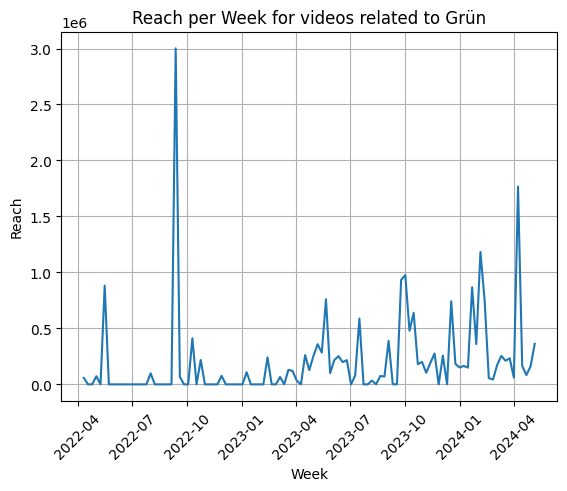

In [405]:

# Convert timestamps to datetime objects
dates = pd.to_datetime(filtered_df["video_timestamp"], unit='s')
reach = filtered_df["video_playcount"]

# Create a DataFrame with dates and reach values
data = pd.DataFrame({'Date': dates, 'Reach': reach})

# Group data by week and sum reach values
weekly_reach = data.resample('W-Mon', on='Date').sum()

# Plot the reach per week
plt.plot(weekly_reach.index, weekly_reach['Reach'])
plt.xlabel('Week')
plt.ylabel('Reach')
plt.title('Reach per Week for videos related to '+ word)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Overall reach per week 

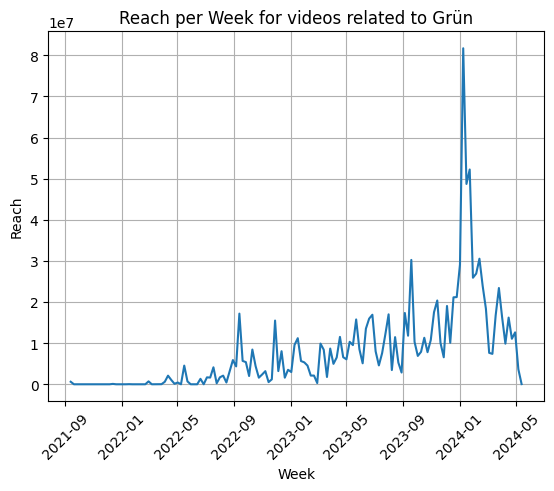

In [406]:
# Convert timestamps to datetime objects
dates = pd.to_datetime(df_cm["video_timestamp"], unit='s')
reach = df_cm["video_playcount"]

# Create a DataFrame with dates and reach values
data = pd.DataFrame({'Date': dates, 'Reach': reach})

# Group data by week and sum reach values
weekly_reach = data.resample('W-Mon', on='Date').sum()

# Plot the reach per week
plt.plot(weekly_reach.index, weekly_reach['Reach'])
plt.xlabel('Week')
plt.ylabel('Reach')
plt.title('Overall reach per week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Topic covered this year per week 

In [412]:
df_cm.topic_title[:10]

0    Protestbewegungen und politische Unzufriedenhe...
1    Bauernproteste: Wut gegen die Bundesregierung ...
2    Unzufriedenheit mit der politischen Situation ...
3    Die schleichende Zerstörung Deutschlands: Krit...
4    Rentenproblematik in Deutschland: Altersarmut,...
5    "Kritik am politischen Establishment und Forde...
6    Forderung nach einer restriktiven Einwanderung...
7    Die Grünen kritisieren: Angriffe auf politisch...
8    Deutschland in der Krise: Herausforderungen un...
9    Die schleichende Zerstörung Deutschlands: Krit...
Name: topic_title, dtype: object

In [424]:
tr="Grün"
group_topics(tr)

'Grüne'

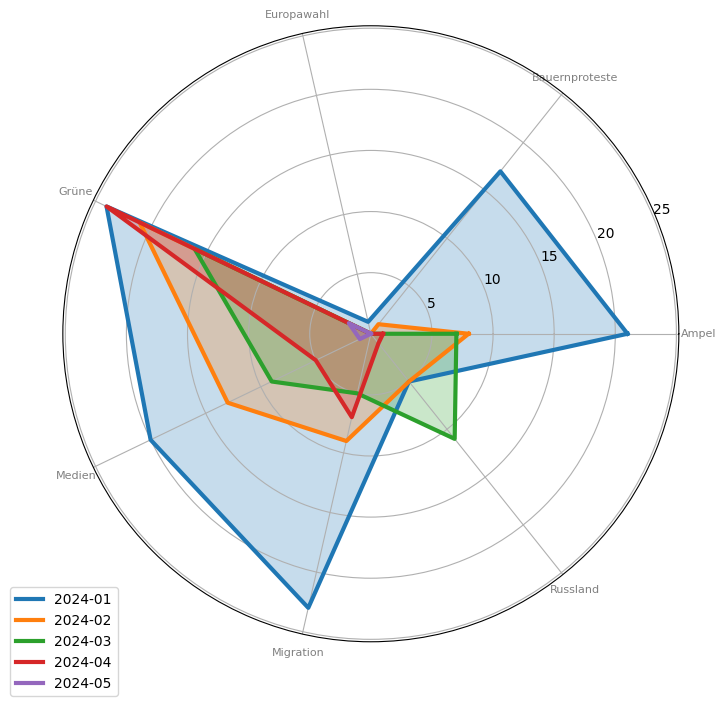

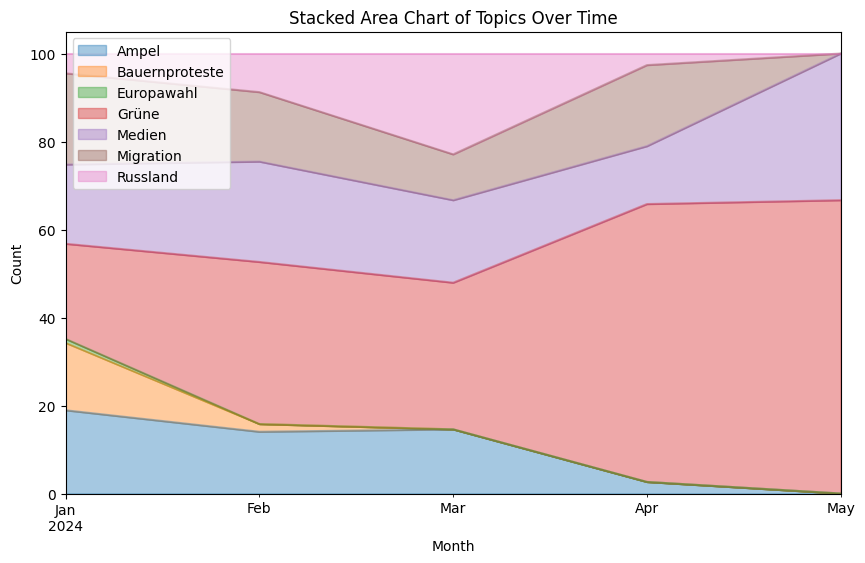

In [422]:
# Grouping function
def group_topics(topic):
    topic = topic.lower()
    if 'migration' in topic:
        return 'Migration'
    elif 'grün' in topic:
        return 'Grüne'
    elif 'ampel' in topic:
        return 'Ampel'
    elif 'europawahl' in topic:
        return 'Europawahl'
    elif 'medien' in topic:
        return 'Medien'
    elif 'russland' in topic:
        return 'Russland'
    elif 'bauernprotest' in topic:
        return 'Bauernproteste'
    else:
        return 'Other'

# Apply grouping
df_cm['grouped_topic'] = df_cm['core_message'].apply(group_topics)

# Convert timestamp to datetime
df_cm['video_timestamp'] = pd.to_datetime(df_cm['video_timestamp'], unit='s')

# Extract month and year
df_cm['year_month'] = df_cm['video_timestamp'].dt.to_period('M')

df_cm_filtered = df_cm[df_cm['video_timestamp'].dt.year >= 2024]
df_cm_filtered = df_cm_filtered[df_cm_filtered['grouped_topic'] != 'Other']
# Aggregate data by month and topic
monthly_data = df_cm_filtered.groupby(['year_month', 'grouped_topic']).size().unstack().fillna(0)

# Radar Chart
categories = monthly_data.columns
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each month
months = monthly_data.index
for month in months:
    values = monthly_data.loc[month].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=3, linestyle='solid', label=str(month))
    ax.fill(angles, values, alpha=0.25)  # Fill with shading

# Add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()
# Normalize the data to 100% for each month
monthly_data_percentage = monthly_data.div(monthly_data.sum(axis=1), axis=0) * 100

# Stacked Area Chart
monthly_data_percentage.plot.area(figsize=(10, 6), alpha=0.4)
plt.title('Stacked Area Chart of Topics Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()


# Data analyses

### Count hashtags by pure frequency

In [77]:
from collections import Counter

def return_hashtags(document):
    # Extract hashtags from descriptions
    hashtags = [word.lower() for description in document for word in description.split() if word.startswith("#")]

    # Count the frequency of each hashtag
    hashtag_counts = Counter(hashtags)

    # Sort hashtags by frequency
    sorted_hashtags = sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_hashtags_array=np.array([list(pair) for pair in sorted_hashtags])
    return sorted_hashtags_array

docs_non_right=docs[result!="right"]

sorted_hashtags=return_hashtags(docs_clean)
sorted_hashtags_nr=return_hashtags(docs_non_right)


In [112]:
def filter_common_hashtags(array1, array2, threshold=10):
    # Extract hashtags and counts from the arrays
    hashtags1, counts1 = array1[:, 0], array1[:, 1].astype(int)
    hashtags2, counts2 = array2[:, 0], array2[:, 1].astype(int)
    
    # Apply threshold to array2
    array2 = array2[counts2 > threshold]
    hashtags2, counts2 = array2[:, 0], array2[:, 1].astype(int)
    
    # Find common hashtags
    common_hashtags = set(hashtags1) & set(hashtags2)
    
    # Filter array1 to remove entries with common hashtags
    filtered_array1 = array1[~np.isin(array1[:, 0], list(common_hashtags))]
    
    return filtered_array1

In [114]:
sorted_hashtags_filtered= filter_common_hashtags(sorted_hashtags, sorted_hashtags_nr)

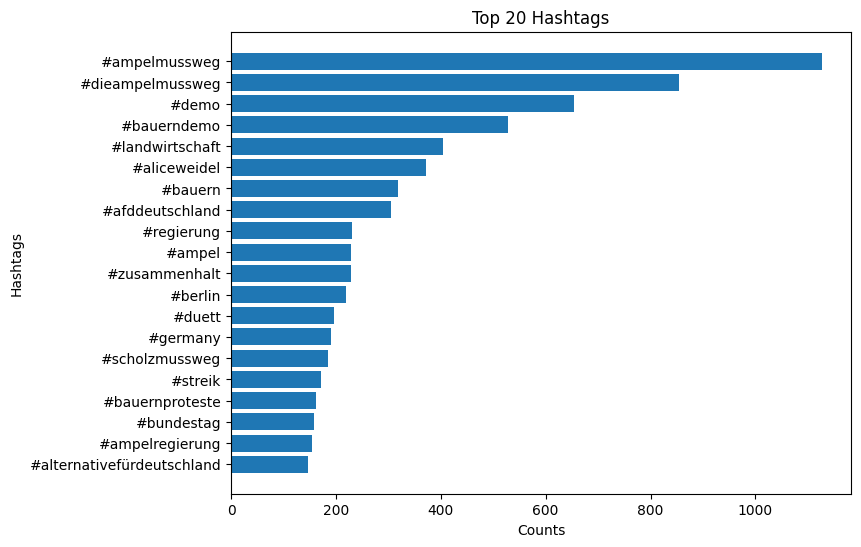

In [118]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.barh(sorted_hashtags_filtered[:20,0],sorted_hashtags_filtered[:20,1].astype(int))  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Counts')
plt.ylabel('Hashtags')
plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

### Count hashtags per week of video publication

In [195]:

def most_trending_hashtag_per_week(df, date_column, hashtags_column):
    """
    Display the most trending hashtag per week based on the date of video publication.

    Args:
    - df (pandas.DataFrame): DataFrame containing the data.
    - date_column (str): Name of the column containing the date of video publication.
    - hashtags_column (str): Name of the column containing hashtags.

    Returns:
    - pandas.DataFrame: DataFrame containing the most trending hashtags per week with the most reach.
    """

    # Convert date of video publication to year and week number
    df['Week'] = pd.to_datetime(df[date_column], format='%Y-%m-%d %H:%M:%S', errors='coerce').fillna(
        pd.to_datetime(df[date_column], format='%Y-%m-%dT%H:%M:%S', errors='coerce')).dt.strftime('%Y-%U')

    # Create a dictionary to store the count of hashtags for each year and week
    weekly_hashtags_count = defaultdict(lambda: defaultdict(int))

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        year_week = row['Week']
        hashtags = re.findall(r'#\w+', str(row[hashtags_column]))
        for hashtag in hashtags:
            weekly_hashtags_count[year_week][hashtag] += 1

    # Initialize an empty list to store the results
    results = []

    # Iterate over each year and week
    for year_week, hashtags_count in weekly_hashtags_count.items():
        # Find the top 3 hashtags for the year and week with the most reach
        top_hashtags = sorted(hashtags_count, key=hashtags_count.get, reverse=True)[:3]
        for hashtag in top_hashtags:
            results.append({'Year_Week': year_week,
                            'Hashtag': hashtag,
                            'Count': hashtags_count[hashtag]})

    # Convert the list of results to a DataFrame
    most_trending_per_week = pd.DataFrame(results)
    most_trending_per_week = most_trending_per_week.sort_values(by='Year_Week')

    return most_trending_per_week

In [196]:
most_trending_per_week = most_trending_hashtag_per_week(df_filtered, "video_timestamp", "video_description")
print(most_trending_per_week)

   Year_Week                 Hashtag  Count
78   2023-26       #ahrtalhochwasser      1
79   2023-26  #wasdenktihrwerihrseit      1
80   2023-26         #politikerlügen      1
86   2023-28                  #viral      1
85   2023-28    #nationalbewusstsein      1
..       ...                     ...    ...
51   2024-17                    #afd     11
53   2024-17         #afddeutschland      6
88   2024-18             #düsseldorf      1
87   2024-18                 #weidel      1
89   2024-18            #kämpferherz      1

[90 rows x 3 columns]


### Count hashtags by cummulative reach

In [165]:
df_filtered=df[:][result=="right"]
df_filtered_nr=df[:][result!="right"]

In [166]:
from collections import defaultdict
import re

def calculate_cumulative_reach_from_description(df, description_column, reach_column):
    """
    Calculate the cumulative reach per hashtag found in the description column of the DataFrame.

    Args:
    - df (pandas.DataFrame): DataFrame containing the data.
    - description_column (str): Name of the column containing descriptions.
    - reach_column (str): Name of the column containing reach/count.

    Returns:
    - dict: Dictionary containing each hashtag and its cumulative reach.
    - int: Total cumulative reach.
    """

    # Create a dictionary to store cumulative reach for each hashtag
    hashtags_reach = defaultdict(int)

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        description = row[description_column]
        reach = row[reach_column]

        # Find all hashtags in the description using regex
        hashtags = re.findall(r'#\w+', str(description))
        for hashtag in hashtags:
            hashtags_reach[hashtag] += reach

    # Sort the dictionary by reach in descending order
    sorted_hashtags_reach = np.array(sorted(hashtags_reach.items(), key=lambda x: x[1], reverse=True))
    sorted_hashtags_reach[:,1]=sorted_hashtags_reach[:,1].astype(int)

    return sorted_hashtags_reach


In [167]:
hashtags_reach = calculate_cumulative_reach_from_description(df_filtered, "video_description", "video_playcount")
hashtags_reach_nr = calculate_cumulative_reach_from_description(df_filtered_nr, "video_description", "video_playcount")

In [168]:
sorted_hashtags_filtered= filter_common_hashtags(hashtags_reach, hashtags_reach_nr, threshold=1000000)

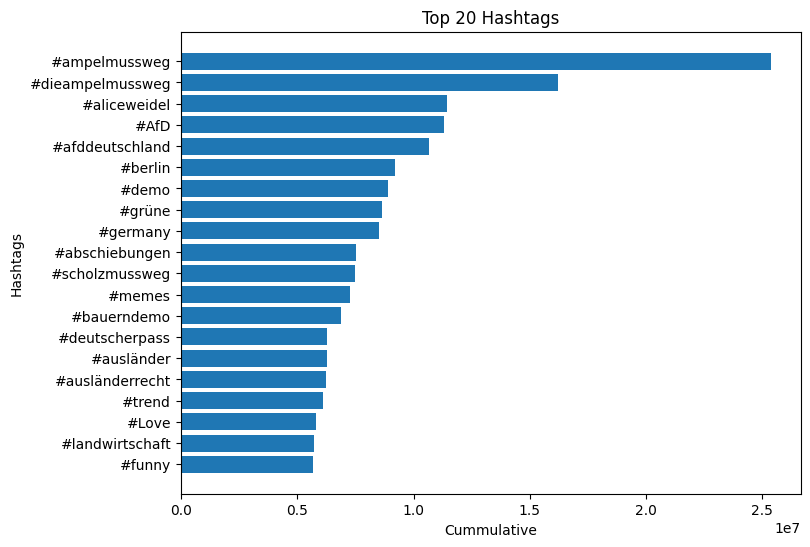

In [173]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.barh(sorted_hashtags_filtered_count[:20,0],sorted_hashtags_filtered_count[:20,1].astype(int))  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Cummulative')
plt.ylabel('Hashtags')
plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

Add Cluster labels to dataframe

Remove documents that are not in a cluster

In [212]:
df_clean = df_clean.query("cluster != -1")

Print numbers of cluster entities

In [214]:
print(df_clean.cluster.value_counts())

cluster
99     55
194    32
180    21
176    20
106    19
       ..
37      3
83      3
142     3
66      3
128     3
Name: count, Length: 218, dtype: int64


In [215]:
# get rows with cluster id 0 and show urls
df_clean.query("cluster == 0")

,video_id,video_timestamp,video_duration,video_locationcreated,video_diggcount,video_description,author_username,suggested_words,video_playcount,Unnamed: 0,...,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified,url,english_transcript,german_transcript,cluster
2899,7344779279537851680,2024-03-10 16:54:54,66,DE,105531,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,afd eines lers 🙏🏾leroyen sch twitch leroyen le...,1375426,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2923,7331423849877097760,2024-02-03 17:09:01,83,DE,11110,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,youtube leroyen die ergibt sinn💀😭 leroy2real k...,153302,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2924,7329938788854140192,2024-01-30 17:06:13,95,DE,42028,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,youtube leroyen team sein leroy2real twitch ta...,475668,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2975,7333653936831843616,2024-02-09 17:22:52,62,DE,22033,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,twitch 🙏🏾leroyen ergibt keinen die sinn youtub...,303560,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3023,7330676559218576672,2024-02-01 16:49:07,70,DE,17598,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,youtube gehören?!😭💀 leroyen ren geh afd leroy2...,238383,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3434,7329568047935556897,2024-01-29 17:07:33,68,DE,83651,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,wechseln leroyen leroy2real twitch sp unbeding...,1133436,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Create a Wordcloud

In [221]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re
import string
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pechenovae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pechenovae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [222]:
def preprocess_text(text):
    # Checking if the input is a string
    if isinstance(text, str):
        # Converting to lowercase
        text = text.lower()
        # Removing punctuation
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        # Removing non-alphabetic characters
        text = re.sub('\W', ' ', text)
        # Removing long strings of whitespace
        text = re.sub('\s+', ' ', text).strip()
        # Removing äh
        text = re.sub('äh', ' ', text).strip()
        # Removing mal
        text = re.sub('mal', ' ', text).strip()
        # Removing ja
        text = re.sub('ja', ' ', text).strip()
        # Tokenizing the text
        words = word_tokenize(text)
        # Removing stopwords
        stop_words = set(stopwords.words('german'))
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    else:
        # Asking to return an empty string if the input is not a string
        return ''

In [223]:
cleaned_docs = [preprocess_text(docs[i]) for i in range(len(docs))]

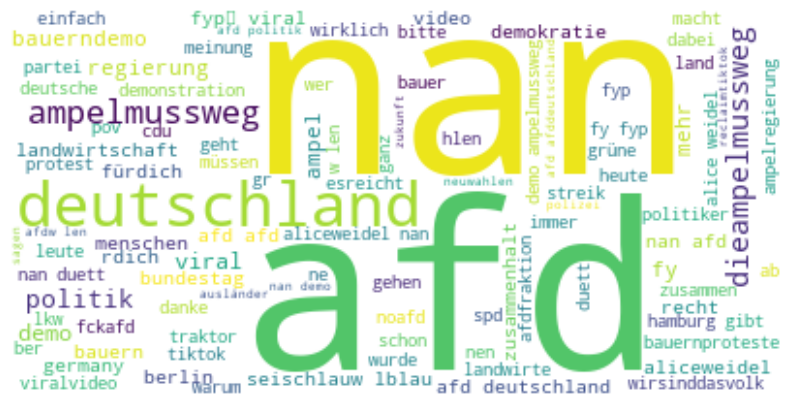

In [224]:
wordcloud_signature = WordCloud(background_color = 'white', max_words = 100).generate(' '.join(cleaned_docs))

# Displaying the word cloud for the signatures
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_signature, interpolation = 'bilinear')
plt.axis('off')
plt.show()